# Notebook of expected goals project

# Imports and setup

In [1]:
import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_data = pd.read_csv("Shots3_dataset.csv")

# Select features for further analysis
features = ["result", "X", "Y", "situation", "season", "shotType", "lastAction"]

df_data = df_data[features]

df_data.head()

,result,X,Y,situation,season,shotType,lastAction
0,MissedShots,0.707,0.379,FromCorner,2015,RightFoot,Aerial
1,SavedShot,0.728,0.373,SetPiece,2015,RightFoot,Pass
2,OwnGoal,0.016,0.464,SetPiece,2015,Head,Foul
3,MissedShots,0.875,0.521,FromCorner,2015,Head,Aerial
4,MissedShots,0.707,0.379,FromCorner,2015,RightFoot,Aerial


In [3]:
# Create binary 'goal' feature from 'result' == 'Goal'
df_data["goal"] = pd.Series(0, index=df_data.index)
df_data.loc[df_data["result"] == "Goal", "goal"] = 1

# Create 'shotType' value 'Foot' from 'RightFoot' and 'LeftFoot' values
df_data.loc[df_data["shotType"].str.contains("Foot"), "shotType"] = "Foot"

df_data.head()

,result,X,Y,situation,season,shotType,lastAction,goal
0,MissedShots,0.707,0.379,FromCorner,2015,Foot,Aerial,0
1,SavedShot,0.728,0.373,SetPiece,2015,Foot,Pass,0
2,OwnGoal,0.016,0.464,SetPiece,2015,Head,Foul,0
3,MissedShots,0.875,0.521,FromCorner,2015,Head,Aerial,0
4,MissedShots,0.707,0.379,FromCorner,2015,Foot,Aerial,0


In [4]:
df_data.describe()

,X,Y,season,goal
count,268692.000000,268692.000000,268692.000000,268692.000000
mean,0.841697,0.504432,2016.256963,0.104916
std,0.090271,0.130944,1.666024,0.306445
min,0.000000,0.000000,2014.000000,0.000000
25%,0.777000,0.412000,2015.000000,0.000000
50%,0.860000,0.501000,2016.000000,0.000000
75%,0.907000,0.598000,2018.000000,0.000000
max,0.999000,0.997000,2020.000000,1.000000


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268692 entries, 0 to 268691
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   result      268692 non-null  object 
 1   X           268692 non-null  float64
 2   Y           268692 non-null  float64
 3   situation   268692 non-null  object 
 4   season      268692 non-null  int64  
 5   shotType    268692 non-null  object 
 6   lastAction  268692 non-null  object 
 7   goal        268692 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 16.4+ MB


## Visualize data

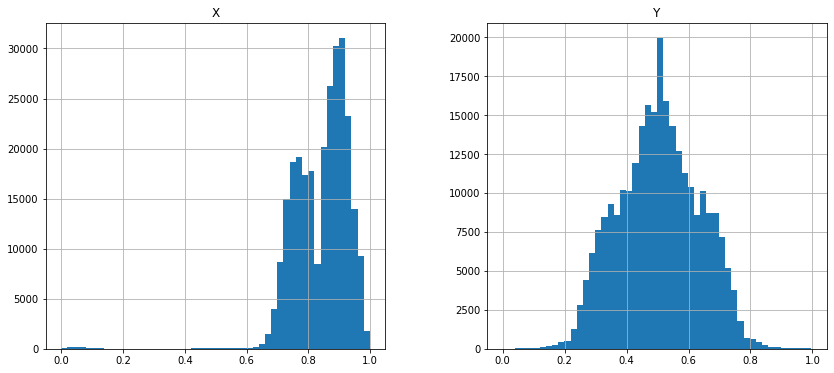

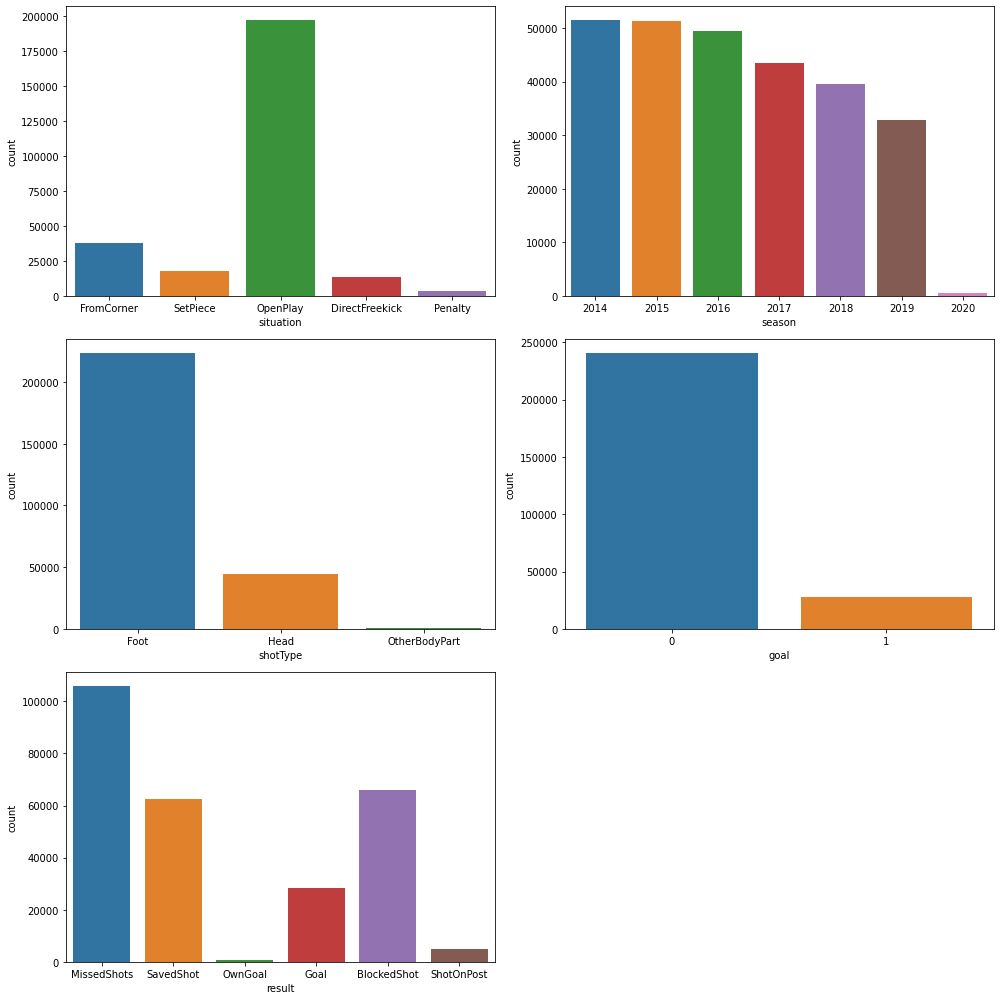

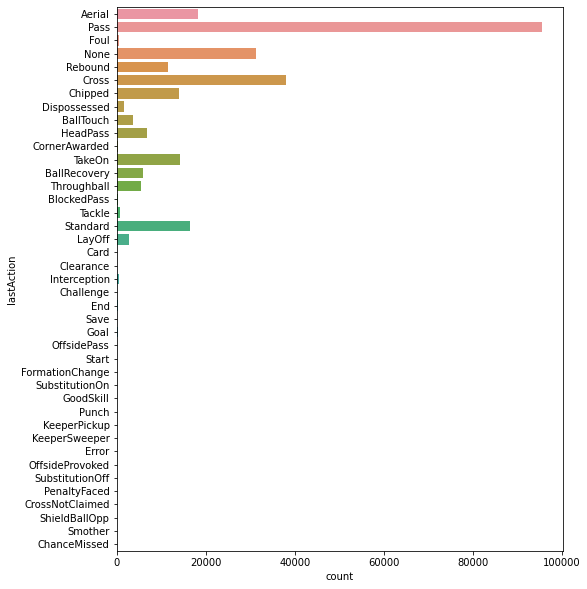

In [6]:
# Plot distributions of 'X' and 'Y coordinates

df_data[["X", "Y"]].hist(figsize=(14,6), bins=50)
plt.show()

# Create count plots of selected features
fig, ax = plt.subplots(nrows=3, ncols=2)

sns.countplot(data=df_data, x="situation", ax=ax[0][0])
sns.countplot(data=df_data, x="season", ax=ax[0][1])
sns.countplot(data=df_data, x="shotType", ax=ax[1][0])
sns.countplot(data=df_data, x="goal", ax=ax[1][1])
sns.countplot(data=df_data, x="result", ax=ax[2][0])

fig.delaxes(ax[2][1])
fig.set_size_inches(14,14)
fig.tight_layout()

plt.show()

# Create count plot of 'lastAction' feature

plt.figure(figsize=(8, 10))
sns.countplot(y=df_data["lastAction"])
plt.show()

## Remove selected rows and features

Filter out rows with own goals to remove data noise.<br>
Remove 'result' feature to only work with 'goal' feature.<br>
Remove 'season' feature to make modelling only dependent on game specific situations.

In [7]:
df_data = df_data.loc[~(df_data["result"] == "OwnGoal")]
df_data.drop(columns=["result", "season"], inplace=True)

## Visualize filtered data

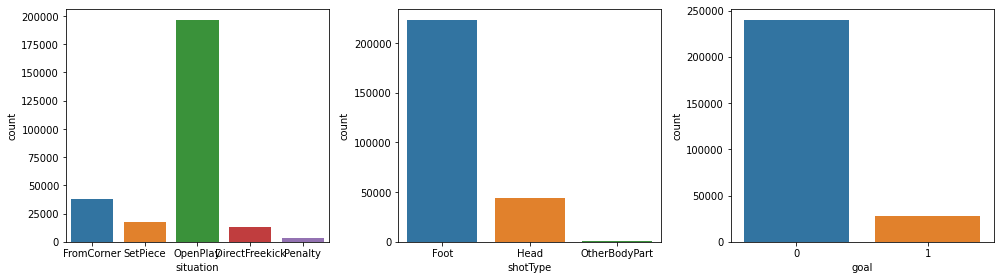

In [8]:
# Create count plots of selected features
fig, ax = plt.subplots(ncols=3)

sns.countplot(data=df_data, x="situation", ax=ax[0])
sns.countplot(data=df_data, x="shotType", ax=ax[1])
sns.countplot(data=df_data, x="goal", ax=ax[2])

fig.set_size_inches(14,4)
fig.tight_layout()
plt.show()

# Visualize coordinates of goals scored

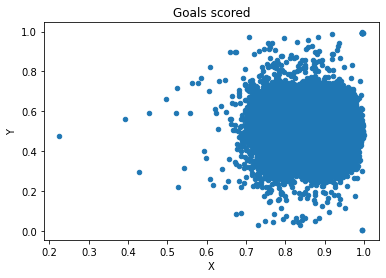

In [9]:
df_data.loc[df_data["goal"] == 1].plot.scatter(x="X", y="Y")
plt.title("Goals scored")
plt.show()

## Feature engineering

Creating new features from the current features.<br>
The centre of the goal is at (X, Y) = (1, 0.5).<br>
Create 'distance' feature representing the euclidean distance from the goal based on the coordinates.<br>
Approximate sizes of the goal and the with of the pitch is used, and the distance in Y-direction is the absolute value of the distance from the goal.<br>
Create 'angle' feature representing the angle of the finish to the goal.<br>
Create 'angle/distance' feature as a combination of the 'angle' and 'distance' features.

In [10]:
field_width = 75
goal_width = 8

# Create distance from goal feature
x_dist = 1 - df_data["X"]
y_dist = (df_data["Y"] - 0.5).abs() - ((goal_width/field_width) / 2)
y_dist[y_dist < 0] = 0
df_data["distance"] = np.sqrt(x_dist**2 + y_dist**2)

# Create angle feature
df_data["angle"] = np.arctan(x_dist/y_dist)

# Create distance/angle feature
df_data["angle/distance"] = df_data["angle"] / df_data["distance"]

## Correlations between numerical features

Calcluating and plotting the correlations between the numerical features as a heatmap.

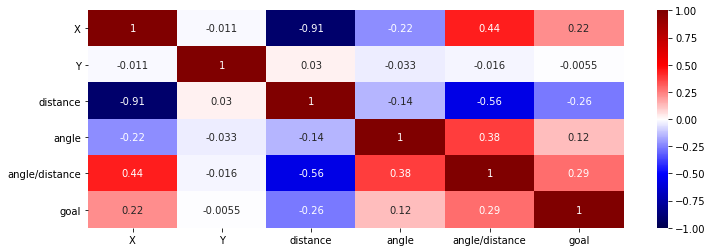

In [11]:
# Place 'goal' column last
df_data["goal"] = df_data.pop("goal")

df_corr = df_data.select_dtypes(include=[np.number]).corr().round(4)

plt.figure(figsize=(2*len(df_corr.columns), len(df_corr.columns)/1.5))
sns.heatmap(df_corr, vmin=-1, vmax=1, center=0, annot=True, cmap="seismic", cbar=True)
plt.show()

# Create machine learning pipeline

Create a machine learning pipeline to test selected models.<br>
The selected models are random forest, XGBoost and CatBoost.<br>
- Select features for training, split data into training and test sets.<br>
- Preprocess data using normalization of numerical features and one-hot encoding of categorical features.<br>
- Perform grid search of hyperparameters using cross-validation to tune models.<br>
- Test models on test set using the best hyperparameters from grid search.<br>

## Select features for analysis

In [12]:
train_features =  ["X", "Y", "distance", "angle", "angle/distance", "situation", "shotType", "lastAction"]

df_data[train_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267880 entries, 0 to 268691
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   X               267880 non-null  float64
 1   Y               267880 non-null  float64
 2   distance        267880 non-null  float64
 3   angle           267880 non-null  float64
 4   angle/distance  267880 non-null  float64
 5   situation       267880 non-null  object 
 6   shotType        267880 non-null  object 
 7   lastAction      267880 non-null  object 
dtypes: float64(5), object(3)
memory usage: 28.4+ MB


## Split data into training and test sets
Stratified split to ensure even distribution of goals in training and test sets.

In [13]:
from sklearn.model_selection import train_test_split

X = df_data[train_features]
y = df_data["goal"]

# Divide the data set into a train set and a test set. Stratified split on target.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

## Preprocessing

Use ColumnTransformer to perform preprocessing of the data.<br>
Normalizing numerical data using MinMaxScaler. One-hot encoding of categorical features.

In [14]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler())
])

categorical_transformer_ohe = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.drop(["X", "Y"])
categorical_features_ohe = X_train.select_dtypes(include=["object"]).columns

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat_ohe", categorical_transformer_ohe, categorical_features_ohe)
    ],
    remainder="passthrough"
)

## Random forest regressor

Create Pipeline object with preprocessing and random forest regressor model.<br>
Perform grid search to select best combination of the hyperparameters given.<br>
Uses k-fold cross-validation with k=5 to evaluate each combination.

In [15]:
from sklearn.ensemble import RandomForestRegressor


rfr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("random_forest", RandomForestRegressor(random_state=1))
])

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "random_forest__n_estimators": [300],
    "random_forest__max_depth": [15],
    "random_forest__max_features": [4]
}

rfr_grid_search_cv = GridSearchCV(rfr_model, cv=5, param_grid=param_grid)
rfr_grid_search_cv.fit(X_train, y_train)

pprint.pprint(rfr_grid_search_cv.best_params_)

{'random_forest__max_depth': 15,
 'random_forest__max_features': 4,
 'random_forest__n_estimators': 300}


Test model with the best hyperparameter combination. Calculate log loss.

In [17]:
rfr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgboost", RandomForestRegressor(n_estimators=rfr_grid_search_cv.best_params_["random_forest__n_estimators"],
                                            max_depth=rfr_grid_search_cv.best_params_["random_forest__max_depth"],
                                            max_features=rfr_grid_search_cv.best_params_["random_forest__max_features"],
                                            random_state=1))
])

rfr_model.fit(X_train, y_train)

y_pred = rfr_model.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

from sklearn.metrics import log_loss
print("Log loss:", "%.7f" % log_loss(y_test, y_pred))

Log loss: 0.2643229


The true probability of each shot is unknown. But the predictions can be split into bins for every percentage of our predicted expected goals value. This can then be compared to the ratio of goals  vs. shots in the same bin. This can give an indicator on how the model performs in different percentage intervals.

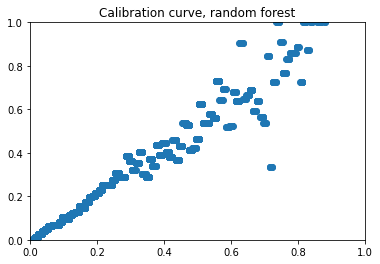

In [18]:
def visualize_results(y_pred, y_test, title):

    df = pd.DataFrame({"pred": y_pred, "result": y_test})

    df["round"] = df.pred.round(2)
    df["mean"] = df.groupby("round").result.transform(np.mean)

    df.loc[df["pred"] < 0.025, "group"] = df.loc[df["pred"] < 0.025, "result"].mean()

    plt.scatter(df["pred"], df["mean"])
    axes = plt.gca()
    axes.set_xlim([0, 1])
    axes.set_ylim([0, 1])
    plt.title(title)
    plt.show()

visualize_results(y_pred=y_pred, y_test=y_test, title="Calibration curve, random forest")

## XGBoost

Repeat the steps of random forest model.

In [19]:
import xgboost as xgb

xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgboost", xgb.XGBRegressor(objective="binary:logistic",
                                 random_state=1))
])

param_grid = {
    "xgboost__n_estimators": [700],
    "xgboost__learning_rate": [0.07],
    "xgboost__max_depth": [3]
}

xgb_grid_search_cv = GridSearchCV(xgb_model, cv=5, param_grid=param_grid)
xgb_grid_search_cv.fit(X_train, y_train)

pprint.pprint(xgb_grid_search_cv.best_params_)

{'xgboost__learning_rate': 0.07,
 'xgboost__max_depth': 3,
 'xgboost__n_estimators': 700}


Log loss: 0.2619507


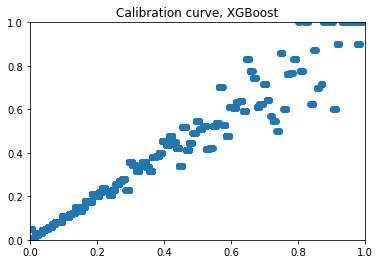

In [20]:
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgboost", xgb.XGBRegressor(objective="binary:logistic",
                                 n_estimators=xgb_grid_search_cv.best_params_["xgboost__n_estimators"],
                                 learning_rate=xgb_grid_search_cv.best_params_["xgboost__learning_rate"],
                                 max_depth=xgb_grid_search_cv.best_params_["xgboost__max_depth"],
                                 random_state=1))
])

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_pred = pd.Series(y_pred, index=y_test.index)

print("Log loss:", "%.7f" % log_loss(y_test, y_pred))
visualize_results(y_pred=y_pred, y_test=y_test, title="Calibration curve, XGBoost")

## CatBoost

Repeat the steps in random forest and XGBoost to see which model that gives the best results.

In [21]:
from catboost import CatBoostClassifier

catboost_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("catboost", CatBoostClassifier(loss_function="Logloss",
                                    verbose=False,
                                    random_state=1))
])

param_grid = {
    "catboost__iterations": [300],
    "catboost__learning_rate": [0.05],
    "catboost__depth": [7]
}

catboost_grid_search_cv = GridSearchCV(catboost_model, cv=5, param_grid=param_grid)
catboost_grid_search_cv.fit(X_train, y_train)

pprint.pprint(catboost_grid_search_cv.best_params_)

{'catboost__depth': 7,
 'catboost__iterations': 300,
 'catboost__learning_rate': 0.05}


Log loss: 0.2615512


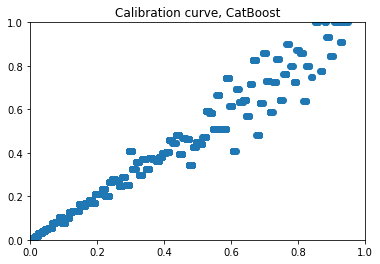

In [22]:
catboost_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("catboost", CatBoostClassifier(loss_function="Logloss",
                                    iterations=catboost_grid_search_cv.best_params_["catboost__iterations"],
                                    learning_rate=catboost_grid_search_cv.best_params_["catboost__learning_rate"],
                                    depth=catboost_grid_search_cv.best_params_["catboost__depth"],
                                    verbose=False,
                                    random_state=1))
])

catboost_model.fit(X_train, y_train)

y_pred = catboost_model.predict_proba(X_test)
y_pred = pd.Series(y_pred[:,1], index=y_test.index)

print("Log loss:", "%.7f" % log_loss(y_test, y_pred))
visualize_results(y_pred=y_pred, y_test=y_test, title="Calibration curve, CatBoost")

## Results from guessing using the mean number of goals

A test to see how the score would be by guessing the mean numer of goals in the data set in each prediction.

In [23]:
mean = df_data["goal"].mean()
y_pred = pd.Series(mean, index=y_test.index)
print("Log loss:", "%.7f" % log_loss(y_test, y_pred))

Log loss: 0.3364327


In [24]:
mean = df_data["goal"].mean()
y_pred = pd.Series(mean, index=y_test.index)
print("Log loss:", "%.7f" % log_loss(y_test, y_pred))

Log loss: 0.3364327


## Results from guessing using the mean number of goals

A test to see how the score would be by guessing the mean numer of goals in the data set in each prediction.

In [25]:
mean = df_data["goal"].mean()
y_pred = pd.Series(mean, index=y_test.index)
print("Log loss:", "%.7f" % log_loss(y_test, y_pred))

Log loss: 0.3364327
